# Python code for generating loss-cone distributions

Python 3.11.5, Numpy 1.26.0, SciPy 1.11.3, Jupyter Notebook 6.5.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [2]:
plt.rcParams['font.family'] = 'Serif'
plt.rcParams["font.size"] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 7
plt.rcParams['figure.figsize'] = (6.4,4.8)

# Gamma generators

In [3]:
# Gamma ganerator for an integer parameter
def gen_gamma_int(a,b):
    x = 1.0
    for i in range(int(a)):
        u = np.random.rand(1)
        x = x * (1-u)
    return -b * np.log(x)

# Gamma ganerator for a half-integer parameter
def gen_gamma_hint(a,b):
    x = 1.0
    for i in range(int(a)):
        u = np.random.rand(1)
        x = x * (1-u)
    x = - np.log(x)
    n = np.random.randn(1)
    x += 0.5*n**2
    return b * x

# Marsaglia & Tsang (2000)'s gamma generator
def gen_gamma(a,b):
    d = a - 1/3
    c = 1 / np.sqrt(9*d)
    while True:
        v = 0
        while v <= 0:
            x = np.random.randn(1)
            v = ( 1 + c*x )
        u = np.random.rand(1)
        v = v**3
        if( 1.0 - 0.0331 * x**4 > u): break
        elif( 0.5*x**2 + d*np.log(v) - d*v + d > np.log(u) ): break
    return d*v*b

particle # : 100000


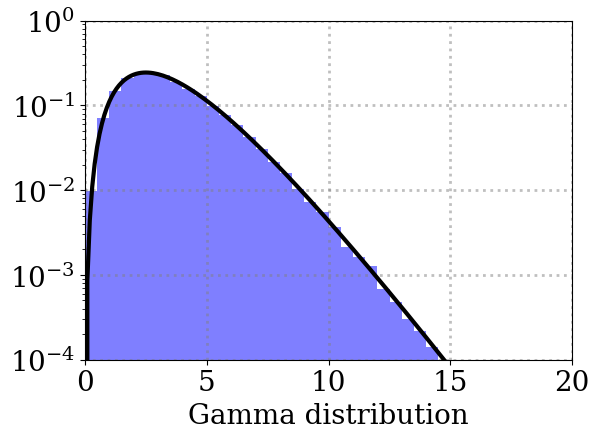

In [4]:
np.random.seed(1227)
mysize=100
mysize=100000
# mysize=1000000

k = 3.5
print("particle # : %d" % mysize )

p = np.ndarray(mysize)
for i in range(mysize):
    p[i] = ( gen_gamma_hint(k,1.0) )[0]
#    p[i] = ( gen_gamma_int(k,1.0) )[0]
#    p[i] = ( gen_gamma(k,1.0) )[0]
#    p[i] = ( np.random.gamma(k,1.0,1) )[0]
# p = np.random.gamma(k,1.0,mysize)

plt.hist(p, 40, color='blue', range=[0,20],density=True,log=True,alpha=0.5)
x = np.arange(0,20.0,0.1)
g = 1/gamma(k) * x**(k-1) * np.exp(-x)
plt.plot(x, g, 'k-', lw=3)
plt.yscale('log')
plt.grid(linestyle='dotted', color='gray', lw=2, alpha=0.5)
plt.xlim(0,20)
plt.ylim(1E-4,1)
plt.xlabel("Gamma distribution")
plt.tight_layout()
plt.show()

# subtracted Maxwellian (AK-type loss-cone distribution)

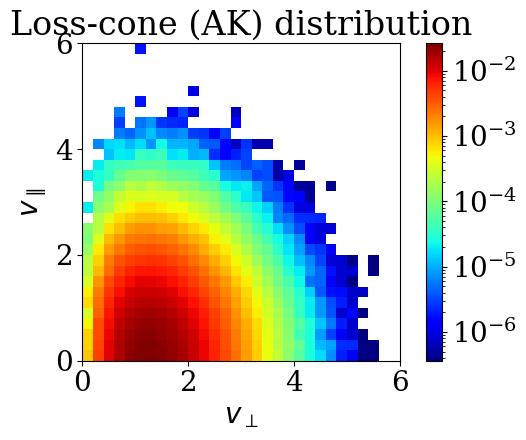

Length:  1000000
0.001149548975268299


In [5]:
import matplotlib
import matplotlib.cm as cm
import scipy as sp

def CYL(vperp,vpara): # for volume
    return 2*np.pi*vperp
def my_weight(vperp,ngrid=5): # for volume
    v1 =  np.floor(ngrid*vperp)     / ngrid
    v2 =( np.floor(ngrid*vperp)+1 ) / ngrid
    return ngrid / ( np.pi * mysize * (v2**2-v1**2) )
#    return ngrid / ( 2 * np.pi * mysize * (v2**2-v1**2) )

# AK distribution
def AAK(vx,vy,vz,theta,beta):
    vperp2 = vx**2 + vy**2
    vpara2 = vz**2
    theta2 = theta**2
    f = 1 / ( np.pi**(3/2) * theta**3 * (1-beta) ) * np.exp( - vpara2 / theta2 ) \
        * ( np.exp( -vperp2 / theta2 ) - np.exp( -vperp2 / (beta*theta2) ) )
    return f
# cylindrical version
def AAKf(vperp,vpara,theta,beta):
    return 2*np.pi*vperp*AAK(vperp,0,vpara,theta,beta)

# parameters
np.random.seed(1227)
mysize=10000
mysize=100000
mysize=1000000
beta = 0.5
theta = 1.5

##### For historical reasons, I used this one in the paper. #####
# r1 = np.ndarray( [mysize] )
# for i in range(mysize):
#     u1 = np.random.rand(1)
#     u2 = np.random.rand(1)
#     r1[i] = ( -np.log(1-u1) - beta*np.log(1-u2) )[0]
# #    r1[i] = ( -np.log(u1) - beta*np.log(u2) )[0]
##### This one is faster. It gives a slightly different KL divergence. #####
u1 = np.random.rand(mysize)
u2 = np.random.rand(mysize)
r1 = -np.log(1-u1) - beta*np.log(1-u2)

# particle velocity
r1 = theta*np.sqrt(r1)
t1 =  2 * np.pi * np.random.rand(mysize)
avx = r1*np.cos(t1)
avy = r1*np.sin(t1)
avz = theta*np.sqrt(0.5)*np.random.randn(mysize)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
AAK0 = ax1.hist2d(r1, np.abs(avz), bins=[np.linspace(0,6,30+1),np.linspace(0,6,30+1)], \
              norm=matplotlib.colors.LogNorm(), weights = 0.5*my_weight(r1,ngrid=5), cmap=cm.jet)
ax1.set_title('Loss-cone (AK) distribution')
ax1.set_xlabel(r'$v_\perp$')
ax1.set_ylabel(r'$v_\parallel$')
ax1.set_aspect('equal')
fig.colorbar(AAK0[3],ax=ax1)
plt.tight_layout()
# plt.savefig('fig_AK.pdf')
plt.show()

# exact solution
myi = len(AAK0[1])-1
myj = len(AAK0[2])-1
AAKe = np.ndarray([myi,myj])
for i in range(myi):
    for jj in range(myj):
        val1, err1 = sp.integrate.dblquad(AAKf, AAK0[1][i], AAK0[1][i+1], AAK0[2][jj], AAK0[2][jj+1], args=(theta,beta))
        val2, err2 = sp.integrate.dblquad(CYL,  AAK0[1][i], AAK0[1][i+1], AAK0[2][jj], AAK0[2][jj+1] )
        AAKe[jj,i] = val1/val2

# Kullback-Leibler divergence
from scipy.stats import entropy
eps=1.0e-10
print( 'Length: ', mysize )
print( entropy(AAKe.reshape(-1)+eps, AAK0[0].reshape(-1)+eps) )

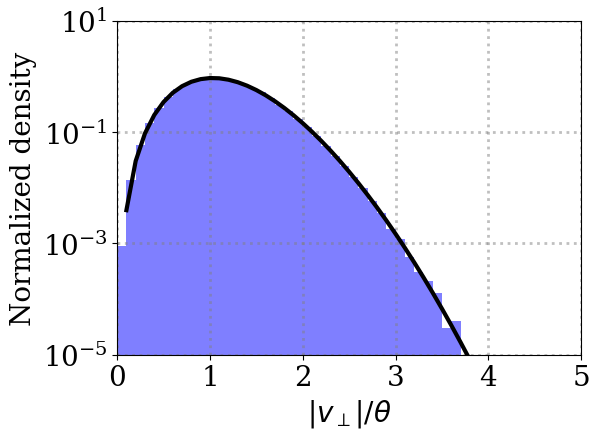

In [6]:
beta=0.5
plt.hist(r1/theta,50,color='blue',range=[0,5],density=True,log=True,alpha=0.5)
xx = np.linspace(0,5,51)
tmp = 2*xx/(1-beta)*(np.exp(-xx**2)-np.exp(-xx**2/beta))
plt.plot(xx[1:],tmp[1:],'k-', lw=3)
plt.grid(linestyle='dotted', color='gray', lw=2, alpha=0.5)
plt.xlim(0,5)
plt.ylim(1E-5,10)
plt.xlabel(r"$|v_\perp|/\theta$")
plt.ylabel("Normalized density")
plt.tight_layout()
# plt.savefig('AK_V.pdf')
plt.show()

# Dory-type loss-cone distribution

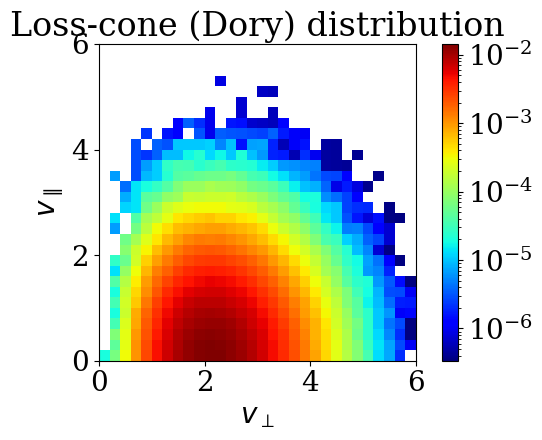

Length:  1000000
0.0013663847961572217


In [7]:
import matplotlib
import matplotlib.cm as cm
import scipy as sp

# Dory (DGH) distribution
def DGH(vx,vy,vz,theta,j):
    vperp2 = vx**2 + vy**2
    vpara2 = vz**2
    f = 1 / ( (np.pi)**(1.5) * theta**(3+2*j) * gamma(j+1) ) * (vperp2**j) * np.exp( -(vperp2+vpara2 ) / (theta**2) )
    return f
# cylindrical version
def DGHf(vperp,vpara,theta,j):
    return 2*np.pi*vperp*DGH(vperp,0,vpara,theta,j)

# parameters
np.random.seed(1227)
mysize=10000
mysize=100000
mysize=1000000
j = 2
theta = 1.5

# particle velocity
r1 = theta * np.sqrt( 0.5 * np.random.gamma( j+1, 2, mysize) )
t1 =  2 * np.pi * np.random.rand(mysize)
dvx = r1*np.cos(t1)
dvy = r1*np.sin(t1)
dvz = np.sqrt(0.5)*theta*np.random.randn(mysize)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
DGH0 = ax1.hist2d(r1, np.abs(dvz), bins=[np.linspace(0,6,30+1),np.linspace(0,6,30+1)], \
              norm=matplotlib.colors.LogNorm(), weights = 0.5*my_weight(r1,ngrid=5), cmap=cm.jet)
ax1.set_title('Loss-cone (Dory) distribution')
ax1.set_xlabel(r'$v_\perp$')
ax1.set_ylabel(r'$v_\parallel$')
ax1.set_aspect('equal')
fig.colorbar(DGH0[3],ax=ax1)
plt.tight_layout()
# plt.savefig('fig_DGH.pdf')
plt.show()

# exact solution
myi = len(DGH0[1])-1
myj = len(DGH0[2])-1
DGHe = np.ndarray([myi,myj])
for i in range(myi):
    for jj in range(myj):
        val1, err1 = sp.integrate.dblquad(DGHf, DGH0[1][i], DGH0[1][i+1], DGH0[2][jj], DGH0[2][jj+1], args=(theta,j))
        val2, err2 = sp.integrate.dblquad(CYL,  DGH0[1][i], DGH0[1][i+1], DGH0[2][jj], DGH0[2][jj+1] )
        DGHe[jj,i] = val1/val2

# Kullback-Leibler divergence
from scipy.stats import entropy
eps=1.0e-10
print( 'Length: ', mysize )
print( entropy(DGHe.reshape(-1)+eps, DGH0[0].reshape(-1)+eps) )

# Summers-type Kappa Loss-Cone (KLC) distribution

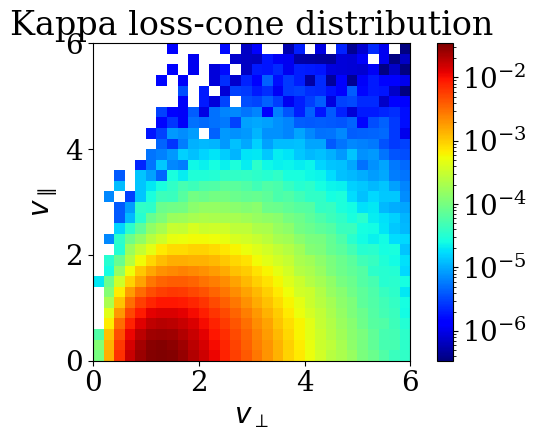

Length:  1000000
0.001486270138935417


In [8]:
import matplotlib
import matplotlib.cm as cm
import scipy as sp

# KLC distribution
def KLC(vx,vy,vz,k,theta,j):
    vperp2 = vx**2 + vy**2
    vpara2 = vz**2
    f1 = gamma(j+k+1) / ( gamma(k-0.5) * gamma(j+1) )
    f = f1 / ( (np.pi)**(1.5) * theta**(3+2*j) * k**(j+1.5) ) * vperp2**j * ( 1.0 + ( vperp2+vpara2 ) / (k*theta**2) )**( - (j+k+1) )
    return f
# cylindrical version
def KLCf(vperp,vpara,k,theta,j):
    return 2*np.pi*vperp*KLC(vperp,0,vpara,k,theta,j)

# parameters
np.random.seed(1227)
mysize=10000
mysize=100000
mysize=1000000
theta=1
k=3.5
j=2

# particle velocity
t00 = 2 * np.pi * np.random.rand(mysize)
r01 = np.random.randn(mysize)
r02 = np.random.gamma(k-0.5, 2, mysize)
r03 = np.random.gamma(  j+1, 2, mysize)
r05 = np.sqrt( k * r03 / r02 )
r06 = np.sqrt( k / r02 )
kvx = r05 * np.cos(t00)
kvy = r05 * np.sin(t00)
kvz = r06 * r01

# plot
fig = plt.figure()
ax0 = fig.add_subplot(111)
KLC0 = ax0.hist2d(r05, np.abs(kvz), bins=[np.linspace(0,6,30+1),np.linspace(0,6,30+1)], \
              norm=matplotlib.colors.LogNorm(), weights=0.5*my_weight(r05,ngrid=5), cmap=cm.jet)
ax0.set_title('Kappa loss-cone distribution')
ax0.set_aspect('equal')
ax0.set_xlabel(r'$v_\perp$')
ax0.set_ylabel(r'$v_\parallel$')
fig.colorbar(KLC0[3],ax=ax0)
plt.tight_layout()
# plt.savefig('fig_KLC.pdf')
plt.show()

# exact solution
myi = len(KLC0[1])-1
myj = len(KLC0[2])-1
KLCe = np.ndarray([myi,myj])
for i in range(myi):
    for jj in range(myj):
        val1, err1 = sp.integrate.dblquad(KLCf, KLC0[1][i], KLC0[1][i+1], KLC0[2][jj], KLC0[2][jj+1], args=(k,1,j))
        val2, err2 = sp.integrate.dblquad(CYL,  KLC0[1][i], KLC0[1][i+1], KLC0[2][jj], KLC0[2][jj+1] )
        KLCe[jj,i] = val1/val2

# Kullback-Leibler divergence
from scipy.stats import entropy
eps=1.0e-10
print( 'Length: ', mysize )
print( entropy(KLCe.reshape(-1)+eps, KLC0[0].reshape(-1)+eps ) )

# PA-type loss-cone distribution

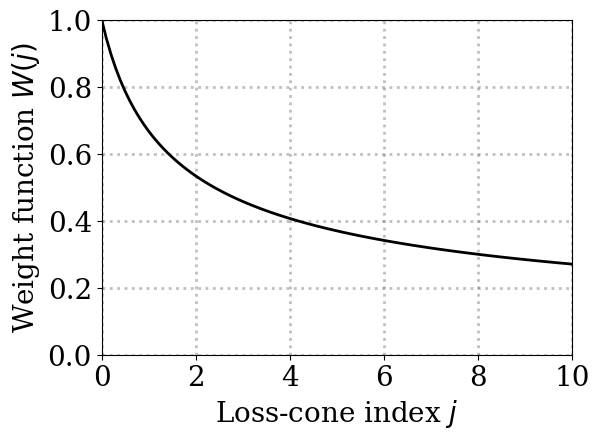

In [9]:
x = np.linspace(0,10,101)
plt.plot( x, (np.sqrt(np.pi)* gamma(x+1))/ (2*gamma(x+1.5)), 'k-' )
plt.xlim(0,10); plt.ylim(0,1)
plt.grid(linestyle='dotted', color='gray', lw=2, alpha=0.5)
plt.xlabel(r'Loss-cone index $j$')
plt.ylabel(r'Weight function $W(j)$')
plt.tight_layout()
# plt.savefig('fig_weight.pdf')
plt.show()

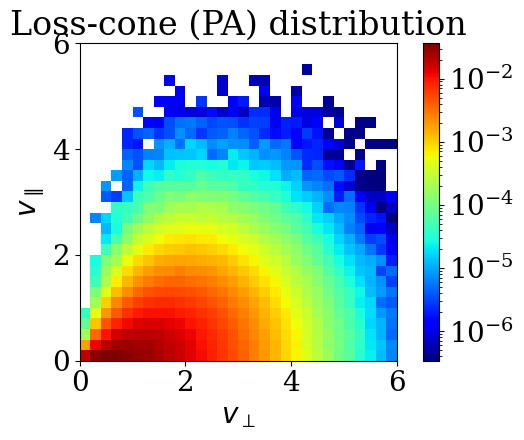

Length:  1000000
0.0008333352098600353


In [10]:
import matplotlib
import matplotlib.cm as cm
import scipy as sp

# PA-type loss-cone distribution
def PA(vx,vy,vz,theta,j):
    vperp2 = vx**2 + vy**2
    vpara2 = vz**2
    f = 2*gamma(j+1.5) / (np.sqrt(np.pi)* gamma(j+1)) / ( (np.pi)**(1.5) * theta**(3) ) * (vperp2/(vperp2+vpara2))**j * np.exp( -(vperp2+vpara2 ) / (theta**2) )
    return f
# cylindrical version
def PAf(vperp,vpara,theta,j):
    return 2*np.pi*vperp*PA(vperp,0,vpara,theta,j)

# parameters
np.random.seed(1227)
mysize=10000
mysize=100000
mysize=1000000
j = 2
theta = 2.0

# particle velocity
n2 = np.random.randn( mysize)
r1 = np.random.gamma( j+1, 2, mysize)
r3 = theta * np.sqrt( np.random.gamma( 1.5, 1, mysize) / (n2*n2+r1) )
r4 = r3 * np.sqrt( r1 )
t1 =  2 * np.pi * np.random.rand(mysize)
svx = r4 * np.cos(t1)
svy = r4 * np.sin(t1)
svz = r3 * n2

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
PA0 = ax1.hist2d(r4, np.abs(svz), bins=[np.linspace(0,6,30+1),np.linspace(0,6,30+1)], \
              norm=matplotlib.colors.LogNorm(), weights = 0.5*my_weight(r4,ngrid=5), cmap=cm.jet)
ax1.set_title('Loss-cone (PA) distribution')
ax1.set_xlabel(r'$v_\perp$')
ax1.set_ylabel(r'$v_\parallel$')
ax1.set_aspect('equal')
fig.colorbar(PA0[3],ax=ax1)
plt.tight_layout()
# plt.savefig('fig_LCPA.pdf')
plt.show()

# exact solution
myi = len(PA0[1])-1
myj = len(PA0[2])-1
PAe = np.ndarray([myi,myj])
for i in range(myi):
    for jj in range(myj):
        val1, err1 = sp.integrate.dblquad(PAf, PA0[1][i], PA0[1][i+1], PA0[2][jj], PA0[2][jj+1], args=(theta,j))
        val2, err2 = sp.integrate.dblquad(CYL, PA0[1][i], PA0[1][i+1], PA0[2][jj], PA0[2][jj+1] )
        PAe[jj,i] = val1/val2

# Kullback-Leibler divergence
from scipy.stats import entropy
eps=1.0e-10
print( 'Length: ', mysize )
print( entropy(PAe.reshape(-1)+eps, PA0[0].reshape(-1)+eps) )

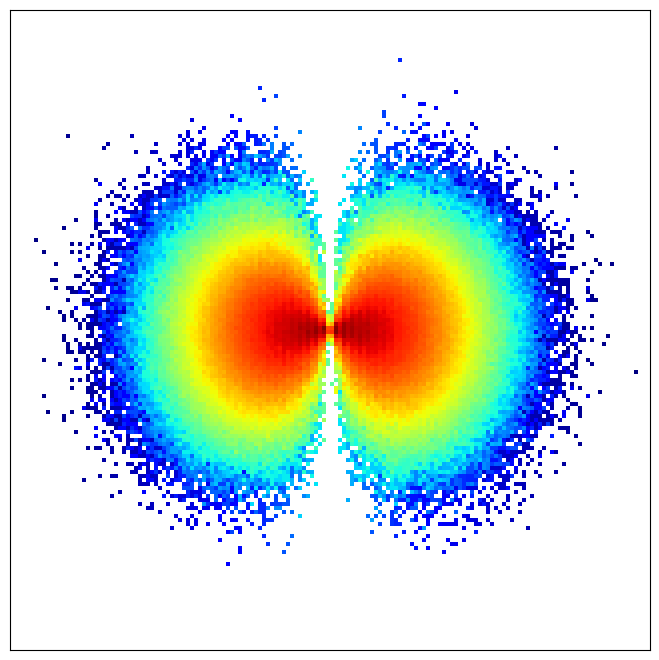

In [11]:
import matplotlib
import matplotlib.cm as cm
import scipy as sp

# parameters
np.random.seed(1227)
mysize=1000000
j = 1
theta = 1

# particle velocity
n2 = np.random.randn( mysize)
r1 = np.random.gamma( j+1, 2, mysize)
r3 = theta * np.sqrt( np.random.gamma( 1.5, 1, mysize) / (n2*n2+r1) )
r4 = r3 * np.sqrt( r1 )
t1 =  2 * np.pi * np.random.rand(mysize)
svx = r4 * np.cos(t1)
svy = r4 * np.sin(t1)
svz = r3 * n2
r42 = (svx>=0.0)*r4 - (svx<0.0)*r4

# fancy plot
fig = plt.figure(figsize=[10,7])
ax1 = fig.add_subplot(111)
PA0 = ax1.hist2d(r42, svz, bins=[np.linspace(-4,4,160+1),np.linspace(-4,4,160+1)], \
              norm=matplotlib.colors.LogNorm(), weights = my_weight(r4,ngrid=10), cmap=cm.jet)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()
# plt.savefig('cover_300.png', dpi=300)
plt.show()

# PA-type Kappa Loss-Cone (KLC) distribution

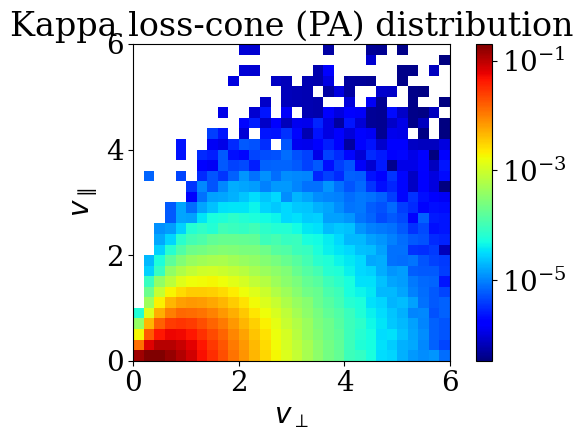

Length:  1000000
0.0005749823828100906


In [12]:
import matplotlib
import matplotlib.cm as cm
import scipy as sp

# PA-type KLC distribution
def KPA(vx,vy,vz,k,theta,j):
    vperp2 = vx**2 + vy**2
    vpara2 = vz**2
    f1 = 2*gamma(j+1.5) / (np.sqrt(np.pi)* gamma(j+1)) * gamma(k+1) / gamma(k-0.5) 
    f = f1 / ( (np.pi)**(1.5) * theta**3 * k**(1.5) ) * (vperp2/(vperp2+vpara2))**j * ( 1.0 + ( vperp2+vpara2 ) / (k*theta**2) )**( - (k+1) )
    return f
# cylindrical version
def KPAf(vperp,vpara,k,theta,j):
    return 2*np.pi*vperp*KPA(vperp,0,vpara,k,theta,j)

# parameters
np.random.seed(1227)
mysize=10000
mysize=100000
mysize=1000000
theta = 1.0
j = 2
k = 3.5

# particle velocity
n2 = np.random.randn( mysize )
r1 = np.random.gamma( j+1, 2, mysize)
r3 = theta * np.sqrt( k * np.random.gamma( 1.5, 1, mysize) / ( np.random.gamma( k-0.5, 1, mysize) * (n2*n2+r1) ))
r4 = r3 * np.sqrt( r1 )
t1 =  2 * np.pi * np.random.rand(mysize)
zvx = r4 * np.cos(t1)
zvy = r4 * np.sin(t1)
zvz = r3 * n2

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
KPA0 = ax1.hist2d(r4, np.abs(zvz), bins=[np.linspace(0,6,30+1),np.linspace(0,6,30+1)], \
              norm=matplotlib.colors.LogNorm(), weights = 0.5*my_weight(r4,ngrid=5), cmap=cm.jet)
ax1.set_title('Kappa loss-cone (PA) distribution')
ax1.set_xlabel(r'$v_\perp$')
ax1.set_ylabel(r'$v_\parallel$')
ax1.set_aspect('equal')
fig.colorbar(KPA0[3],ax=ax1)
plt.tight_layout()
# plt.savefig('fig_KLCPA.pdf')
plt.show()

# exact solution
myi = len(KPA0[1])-1
myj = len(KPA0[2])-1
KPAe = np.ndarray([myi,myj])
for i in range(myi):
    for jj in range(myj):
        val1, err1 = sp.integrate.dblquad(KPAf, KPA0[1][i], KPA0[1][i+1], KPA0[2][jj], KPA0[2][jj+1], args=(k,theta,j))
        val2, err2 = sp.integrate.dblquad(CYL,  KPA0[1][i], KPA0[1][i+1], KPA0[2][jj], KPA0[2][jj+1] )
        KPAe[jj,i] = val1/val2

# Kullback-Leibler divergence
from scipy.stats import entropy
eps=1.0e-10
print( 'Length: ', mysize )
print( entropy(KPAe.reshape(-1)+eps, KPA0[0].reshape(-1)+eps) )

# Numerical test

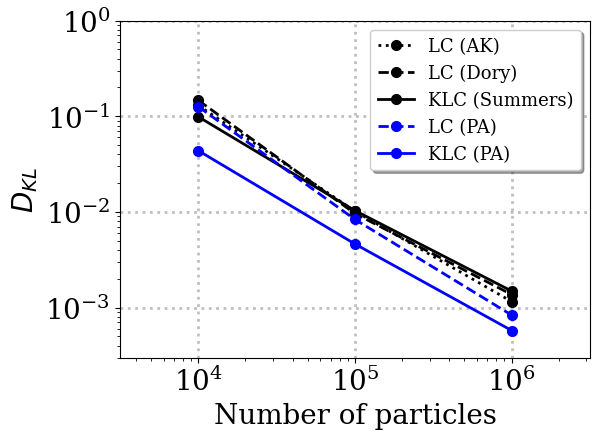

In [13]:
KLAK  = [ [10000, 100000, 1000000], [0.1300754339210337,  0.010157663258467875, 0.0011527301068033852] ]
KLDGH = [ [10000, 100000, 1000000], [0.1467832390554754,  0.009608436552369334, 0.0013663847961572217] ]
KLPA  = [ [10000, 100000, 1000000], [0.12611936094133966, 0.008330936803875857, 0.0008333352098600353] ]
KLKLC = [ [10000, 100000, 1000000], [0.09876777698233219, 0.010311973641507263, 0.001486270138935417] ]
KLKPA = [ [10000, 100000, 1000000], [0.04371217218017581, 0.0046137624969057305, 0.0005749823828100906] ]

plt.plot( KLAK[0] , KLAK[1],  'ko:',  label='LC (AK)')
plt.plot( KLDGH[0], KLDGH[1], 'ko--', label='LC (Dory)' )
plt.plot( KLKLC[0], KLKLC[1], 'ko-' , label='KLC (Summers)')
plt.plot( KLPA[0] , KLPA[1],  'bo--', label='LC (PA)')
plt.plot( KLKPA[0], KLKPA[1], 'bo-',  label='KLC (PA)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**3.5, 10.**6.5)
plt.ylim(0.0003, 1)
plt.xlabel('Number of particles')
plt.ylabel(r'$D_{KL}$')
plt.legend(fontsize=13, shadow=True)
plt.grid(linestyle='dotted', color='gray', lw=2, alpha=0.5)
plt.tight_layout()
# plt.savefig('fig_KL.pdf')
plt.show()